In [1]:
import os
import glob
from os.path import join
import json

from pandas import read_csv, DataFrame
from vega import VegaLite

In [2]:
empo3_dir = '/Users/benkaehler/Data/empo_3/'

In [3]:
prf = read_csv(join(empo3_dir, 'eval_taxa_prf.tsv'), sep='\t')
prf = prf[(prf['level'] == 7) & (prf['method'] == 'weighted')]
prf = prf[(prf['class weights'] == 'bespoke70') | (prf['class weights'] == 'uniform70')]
prf = prf.groupby(['sample type', 'class weights']).mean()

In [4]:
columns = ('type', 'n', 'h', 'weighted_h', 'jsd', 'weighted_jsd',
           'Precision', 'Recall', 'F-measure')
data = {c:[] for c in columns}
for type_dir in glob.glob(join(empo3_dir, '*')):
    if not os.path.exists(join(type_dir, 'results', 'shannon.json')):
        continue
    type_ = os.path.basename(type_dir)
    data['type'].append(type_)
    with open(join(type_dir, 'results', 'shannon.json')) as shannon_file:
        shannon = json.load(shannon_file)
    for k, v in shannon.items():
        data[k].append(v)
    for column in columns[-3:]:
        data[column].append(
            prf[column][type_]['bespoke70'] - prf[column][type_]['uniform70'])
shannon = DataFrame(data)

In [5]:
shannon

,F-measure,Precision,Recall,h,jsd,n,type,weighted_h,weighted_jsd
0,0.045930,0.023462,0.061943,4.703695,1.678253,4769,water-non-saline,4.793743,1.501802
1,0.117092,0.044706,0.150121,4.915176,2.677689,1158,animal-corpus,5.022477,2.579882
2,0.028370,0.010613,0.043788,4.956982,0.614809,328,plant-rhizosphere,4.673926,0.519836
3,0.047741,0.011238,0.067446,5.434253,1.257307,2802,soil-non-saline,5.296395,1.000072
4,0.037822,0.022237,0.050283,5.121340,1.373665,414,sediment-saline,5.196716,1.325386
5,0.192986,0.034666,0.262296,4.007422,1.607815,974,animal-secretion,4.552654,1.886562
6,0.105823,0.024693,0.147527,4.672874,1.802770,1839,animal-surface,4.839412,1.926257
7,0.018551,0.004223,0.030768,3.823037,0.806619,8,plant-surface,3.394275,0.323635
8,0.087966,0.016277,0.124551,3.727922,1.928080,543,plant-corpus,1.768856,1.065912
9,0.068722,0.035811,0.087747,4.844128,2.255175,5632,animal-distal-gut,4.242186,1.945954


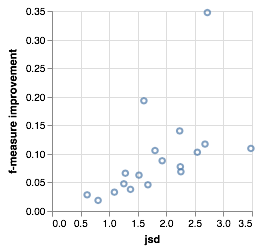

In [15]:
VegaLite({
  "mark": "point",
  "encoding": {
    "x": {"type": "quantitative", "field": "jsd"},
    "y": {"type": "quantitative", "field": "F-measure", "axis": {"title": "f-measure improvement"}},
    "tooltip": [
        {"type": "quantitative", "field": "jsd"},
        {"type": "quantitative", "field": "F-measure"},
        {"type": "ordinal", "field": "type"}
    ]
  }
}, shannon)